In [1]:
import torch
import pandas as pd
import os
from learning_models.sidarthe import Sidarthe
from torch_euler import Heun, euler
from matplotlib import pyplot as plt

In [2]:
params = {
    "alpha": [0.570] * 4 + [0.422] * 18 + [0.360] * 6 + [0.210] * 11,
    "beta": [0.011] * 4 + [0.0057] * 18 + [0.005] * 17,
    "gamma": [0.456] * 4 + [0.285] * 18 + [0.2] * 6 + [0.11] * 11,
    "delta": [0.011] * 4 + [0.0057] * 18 + [0.005] * 17,
    "epsilon": [0.171] * 12 + [0.143] * 26 + [0.2],
    "theta": [0.371] * 39,
    "zeta": [0.125] * 22 + [0.034] * 16 + [0.025],
    "eta": [0.125] * 22 + [0.034] * 16 + [0.025],
    "mu": [0.017] * 22 + [0.008] * 17,
    "nu": [0.027] * 22 + [0.015] * 17,
    "tau": [0.01] * 39,
    "lambda": [0.034] * 22 + [0.08] * 17,
    "kappa": [0.017] * 22 + [0.017] * 16 + [0.02],
    "xi": [0.017] * 22 + [0.017] * 16 + [0.02],
    "rho": [0.034] * 22 + [0.017] * 16 + [0.02],
    "sigma": [0.017] * 22 + [0.017] * 16 + [0.01]
}

i = 200./60e6
d = 20./60e6
a = 1./60e6
r = 2./60e6
t, h, e = 0., 0., 0.
s = 1. - (i + d + a + r + t + h + e)


initial_values = [
        s,
        i,
        d,
        a,
        r,
        t,
        e,
        h,
]

a_len = len(params["alpha"])
for key, value in params.items():
    assert len(value) == a_len, f"{key} has wrong size"


sidarthe = Sidarthe(params, 1, initial_values, euler, 0.01,
                    d_weight=0.,
                    r_weight=0.,
                    t_weight=0.,
                    h_weight=0.,
                    e_weight=0.,
                    der_1st_reg=0.,
                    bound_reg=0.,
                    verbose=False,
                    loss_type="rmse"
                    )

In [3]:
size = 200
t_inc = 0.01
t_grid = torch.linspace(0, size, int(size/t_inc) + 1)
t_slice = slice(0, int(size/t_inc) + 1, int(1/t_inc))

In [4]:
with torch.no_grad():
    inference = sidarthe.inference(t_grid)

In [5]:
new_inference = {}
for k,v in inference.items():
    new_inference[k] = v[t_slice]

In [6]:
print(inference["r0"][700])

tensor(1.6616, dtype=torch.float64)


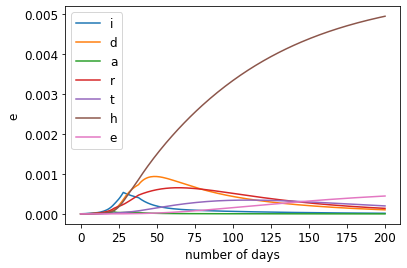

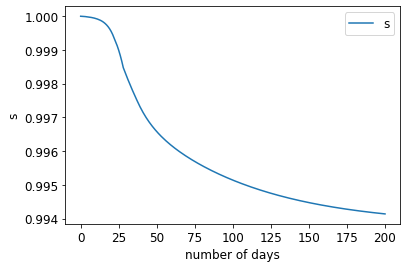

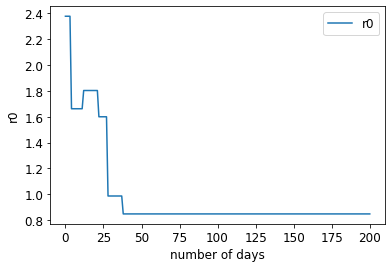

In [7]:
#sol = inference["sol"]

# plot state evolution
base_path = os.path.join(os.getcwd(), "plots")
if not os.path.exists(base_path):
    os.mkdir(base_path)

def build_plot(t_grid, keys_string, inference, base_path, ):
    plt.figure()
    for key in keys_string:
        plt.xlabel("number of days")
        plt.ylabel(key)
        plt.plot(t_grid.numpy(), inference[key], label=key)
        plt.legend()
    plot_filename = os.path.join(base_path, str(keys_string) + '.png') 
    plt.savefig(plot_filename)

build_plot(t_grid[t_slice], 'idarthe', new_inference, base_path)
build_plot(t_grid[t_slice], 's', new_inference, base_path)
build_plot(t_grid[t_slice], ['r0'], new_inference, base_path)

# store parameters and state in a pandas dataframe results
params_df = pd.DataFrame.from_dict(params)
state_df = pd.DataFrame.from_dict(new_inference)
state_df = state_df.drop(columns='sol')
extend = state_df.shape[0]-params_df.shape[0]
params_df = params_df.append(params_df.iloc[[-1]*extend])
params_df.index = range(params_df.shape[0])
results = pd.concat([params_df, state_df], axis=1, sort=False)

# save results to csv
base_path = os.path.join(os.getcwd(), "regioni")
if not os.path.exists(base_path):
    os.mkdir(base_path)
results.to_csv(os.path.join(base_path,'sidarthe_results_new.csv'))
